# Практическая работа 5  
**Выполнил: Воронов А.И. ББМО-01-22**

In [1]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=b973b497ef12bb54f41e3c2dd7125efbe2f4657ad8ce5c6d383cc4327db17d18
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import gray2rgb, rgb2gray, label2rgb # since the code wants color images

In [4]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784')
mnist_data = mnist.data.values.astype(np.uint8)
X_vec = np.stack([gray2rgb(iimg) for iimg in mnist_data.reshape((-1, 28, 28))], 0).astype(np.uint8)
y_vec = mnist.target.astype(np.uint8)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Text(0.5, 1.0, 'Digit: 5')

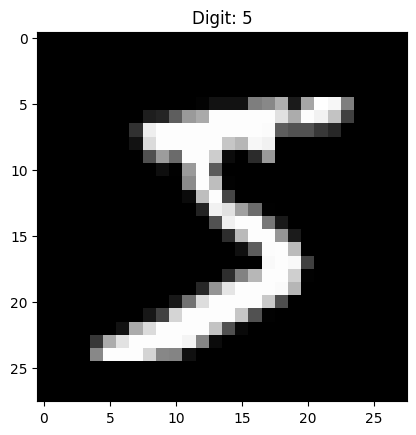

In [5]:
%matplotlib inline
fig, ax1 = plt.subplots(1,1)
ax1.imshow(X_vec[0], interpolation = 'none')
ax1.set_title('Digit: {}'.format(y_vec[0]))

## Настройка конвейера

Создаем конвейер для обработки изображений, где в основном мы сглаживаем изображение обратно до одномерных векторов, а затем используем классификатор случайных лесов

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Normalizer

class PipeStep(object):
    """
    Wrapper for turning functions into pipeline transforms (no-fitting)
    """
    def __init__(self, step_func):
        self._step_func=step_func
    def fit(self,*args):
        return self
    def transform(self,X):
        return self._step_func(X)


makegray_step = PipeStep(lambda img_list: [rgb2gray(img) for img in img_list])
flatten_step = PipeStep(lambda img_list: [img.ravel() for img in img_list])

simple_rf_pipeline = Pipeline([
    ('Make Gray', makegray_step),
    ('Flatten Image', flatten_step),
    #('Normalize', Normalizer()),
    #('PCA', PCA(16)),
    ('RF', RandomForestClassifier())
                              ])

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_vec, y_vec,
                                                    train_size=0.55)

In [8]:
simple_rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('Make Gray', <__main__.PipeStep object at 0x78d5b31a1b70>),
                ('Flatten Image', <__main__.PipeStep object at 0x78d5b31a0880>),
                ('RF', RandomForestClassifier())])

In [9]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime

In [10]:
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
explainer = lime_image.LimeImageExplainer(verbose = False)
segmenter = SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2)

In [11]:
%%time
explanation = explainer.explain_instance(X_test[0],
                                         classifier_fn = simple_rf_pipeline.predict_proba,
                                         top_labels=10, hide_color=0, num_samples=10000, segmentation_fn=segmenter)

  0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: user 7.13 s, sys: 144 ms, total: 7.27 s
Wall time: 7.4 s


Text(0.5, 1.0, 'Positive/Negative Regions for 7')

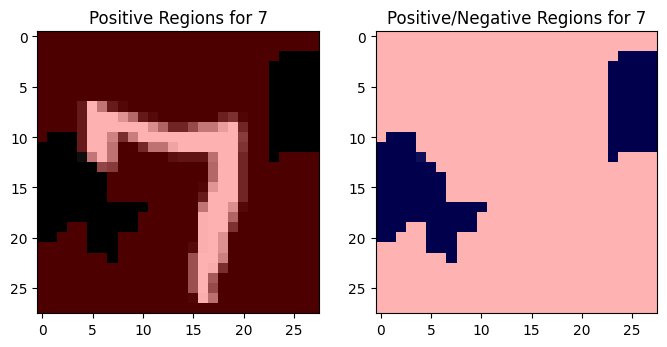

In [13]:
temp, mask = explanation.get_image_and_mask(y_test.iloc[0], positive_only=True, num_features=10, hide_rest=False, min_weight=0.01)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.imshow(label2rgb(mask, temp, bg_label=0), interpolation='nearest')
ax1.set_title('Positive Regions for {}'.format(y_test.iloc[0]))

temp, mask = explanation.get_image_and_mask(y_test.iloc[0], positive_only=False, num_features=10, hide_rest=False, min_weight=0.01)
ax2.imshow(label2rgb(3 - mask, temp, bg_label=0), interpolation='nearest')
ax2.set_title('Positive/Negative Regions for {}'.format(y_test.iloc[0]))

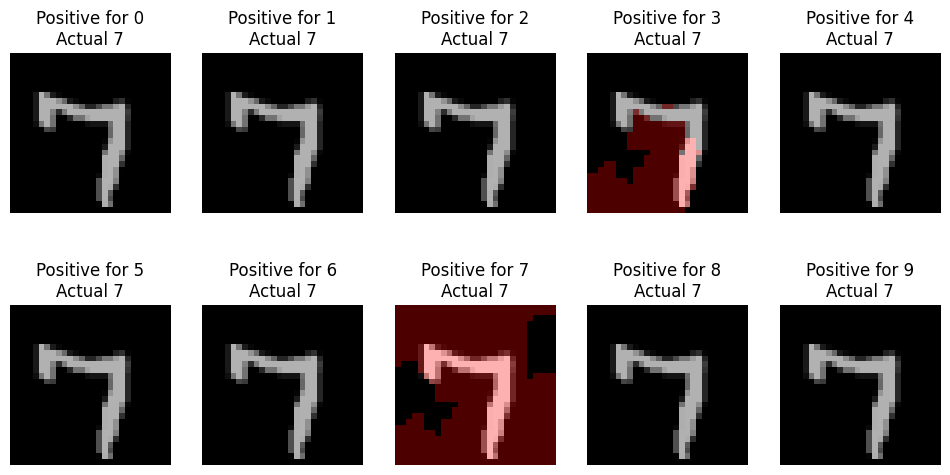

In [16]:
# now show them for each class
fig, m_axs = plt.subplots(2, 5, figsize=(12, 6))
for i, c_ax in enumerate(m_axs.flatten()):
    temp, mask = explanation.get_image_and_mask(i, positive_only=True, num_features=1000, hide_rest=False, min_weight=0.01)
    c_ax.imshow(label2rgb(mask, X_test[0], bg_label=0), interpolation='nearest')
    c_ax.set_title('Positive for {}\nActual {}'.format(i, y_test.iloc[0]))
    c_ax.axis('off')

Объяснение

In [19]:
valid_indices = np.where(pipe_pred_test != y_test)[0]
if len(valid_indices) > 0:
    wrong_idx = np.random.choice(valid_indices)
    print('Using #{} where the label was {} and the pipeline predicted {}'.format(wrong_idx, y_test.iloc[wrong_idx], pipe_pred_test[wrong_idx]))
else:
    print("No misclassified samples found.")

Using #14038 where the label was 0 and the pipeline predicted 3


In [20]:
%%time
explanation = explainer.explain_instance(X_test[wrong_idx],
                                         classifier_fn = simple_rf_pipeline.predict_proba,
                                         top_labels=10, hide_color=0, num_samples=10000, segmentation_fn=segmenter)

  0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: user 7.03 s, sys: 102 ms, total: 7.14 s
Wall time: 7.34 s


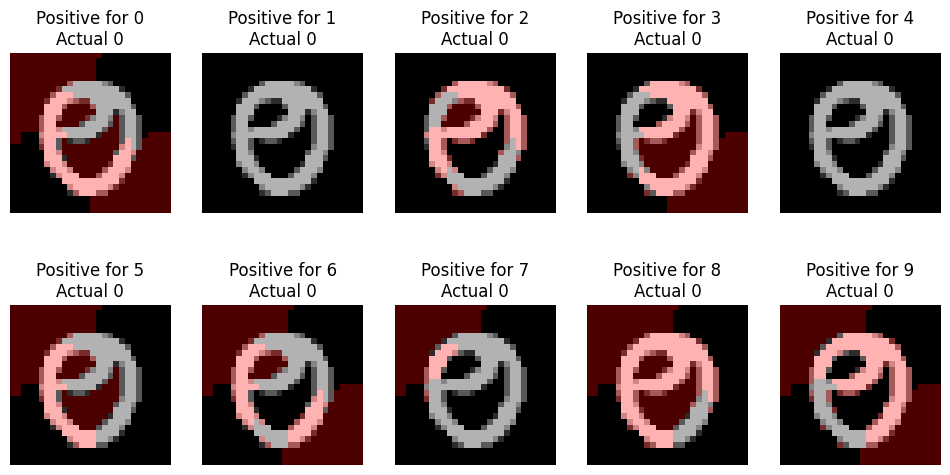

In [22]:
# now show them for each class
fig, m_axs = plt.subplots(2,5, figsize = (12,6))
for i, c_ax in enumerate(m_axs.flatten()):
    temp, mask = explanation.get_image_and_mask(i, positive_only=True, num_features=10, hide_rest=False, min_weight = 0.01 )
    c_ax.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
    c_ax.set_title('Positive for {}\nActual {}'.format(i, y_test.iloc[wrong_idx]))
    c_ax.axis('off')